In [26]:
# load packages
import mne as mne
mne.set_log_level('error')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import mne
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from autoreject import AutoReject

import os

In [132]:
p_id = 'mytest3'

c:\Users\Kya\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


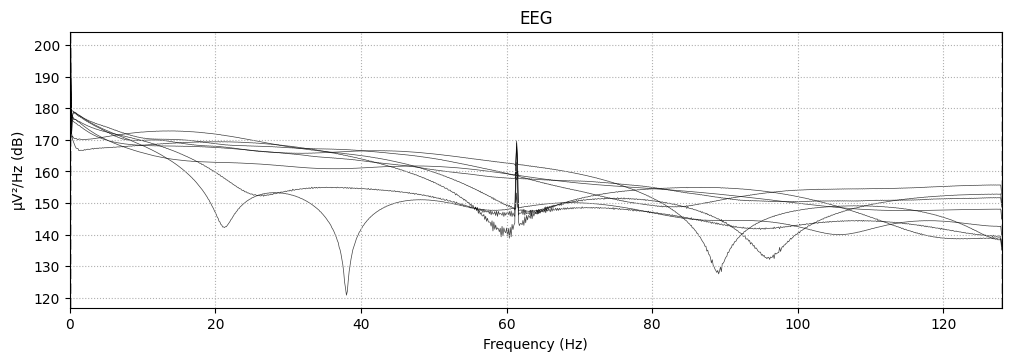

In [133]:
# load data from .csv file name 'combined_recording_##########.csv' from data/recordings folder, use columns 0-7, 17, 19
data = pd.read_csv(f'data/training/{p_id}.csv', usecols=[0,1,2,3,4,5,6,7,18,20])

# channel info (check electode placement/name and columsn in data)
ch_names = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'Type', 'TimeStamp']
sfreq = 256  # sampling frequency in Hz

# channel types (8 channels of EEG data and 2 for image type and stimulus time)
ch_types = ['eeg'] * 8 + ['misc'] * 2

# create info object and raw data object
info = mne.create_info(ch_names, sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data.T, info)
raw.plot_psd()

In [134]:
# Preprocessing params

# Filter settings
low_cut = .1
low_cut_ica = 1
high_cut = 30

# ICA
tstep = 1.0
tmin_ica = 0.0
ica_rand_state = 42
ica_n_components = 0.99

# AutoReject
n_jobs = -1
ar_rand_state = ica_rand_state

# Epoch settings
tmin =  -.200  
tmax =  2.000
baseline = (tmin, 0)

In [135]:
# rename channels to match MNE conventions
raw = raw.rename_channels(mapping={'CH1': 'Fp1', 'CH2': 'Fp2', 'CH3': 'F3', 'CH4': 'F4', 'CH5': 'C3', 'CH6': 'C4', 'CH7': 'P3', 'CH8': 'P4'})


In [136]:
# apply filters to raw data
raw.set_montage('biosemi16')

raw.apply_function(lambda x: x * 1e-6)

raw_filt = raw.copy().filter(low_cut, high_cut)

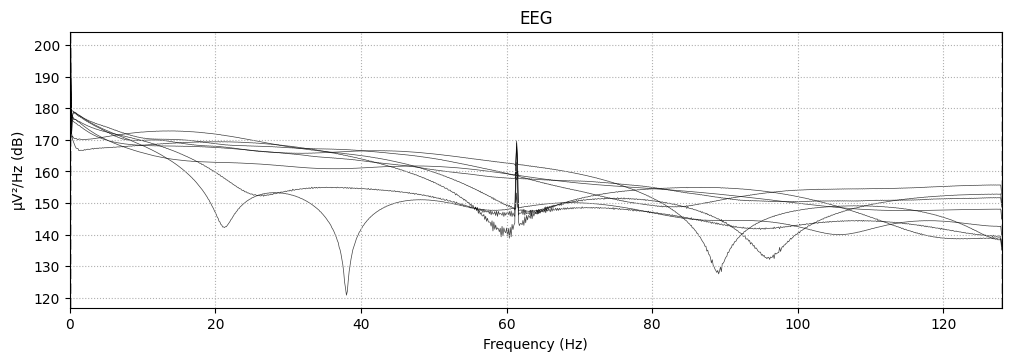

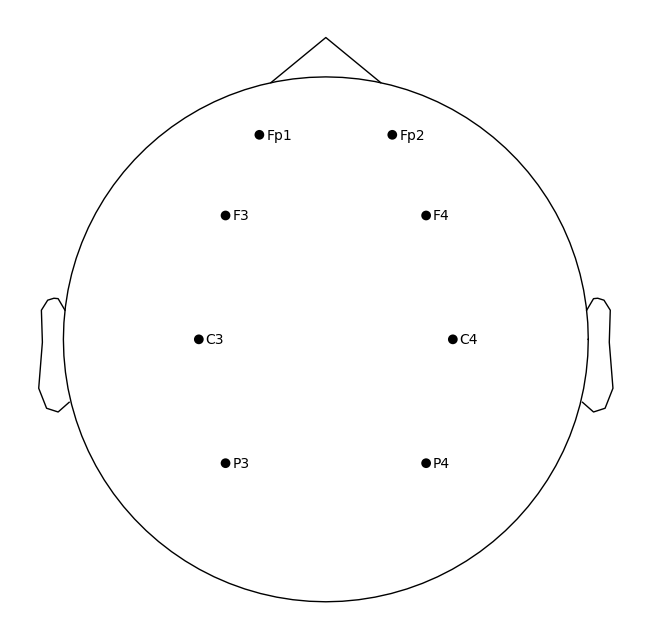

In [137]:
# plot raw data electrode locations and names
raw_plotted = raw.plot_sensors(show_names=True)

c:\Users\Kya\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


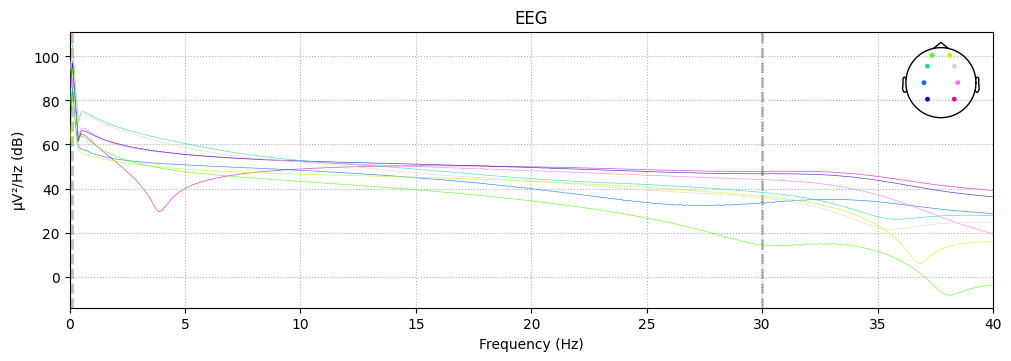

In [138]:
raw_filt.plot_psd(fmin=0, fmax=40)

In [139]:
# save filtered raw data
# raw_filt.save('data/training/'  + participant_id + '-filtered.fif', overwrite=True)

In [140]:
# filter a new copy of the raw data for ICA
raw_filt_ica = raw.copy().filter(low_cut_ica, high_cut)

In [141]:
# Break raw data into 1 s epochs
events_ica = mne.make_fixed_length_events(raw_filt_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_filt_ica, events_ica,
                        tmin=tmin, tmax=tmax,
                        baseline=baseline,
                        preload=True)

In [142]:
# Instantiate 
ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info,
                                     eeg=True,
                                     eog=False
                                     ),
                n_jobs=1,
                verbose=False
                )

# Fit
ar.fit(epochs_ica)

# Generate log
reject_log = ar.get_reject_log(epochs_ica)

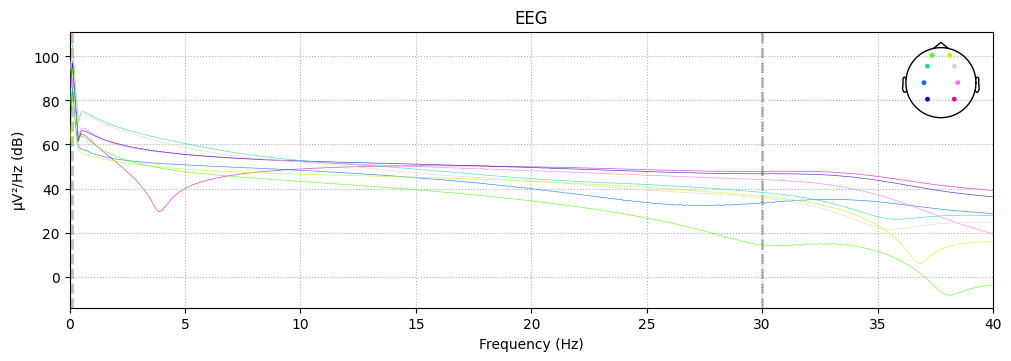

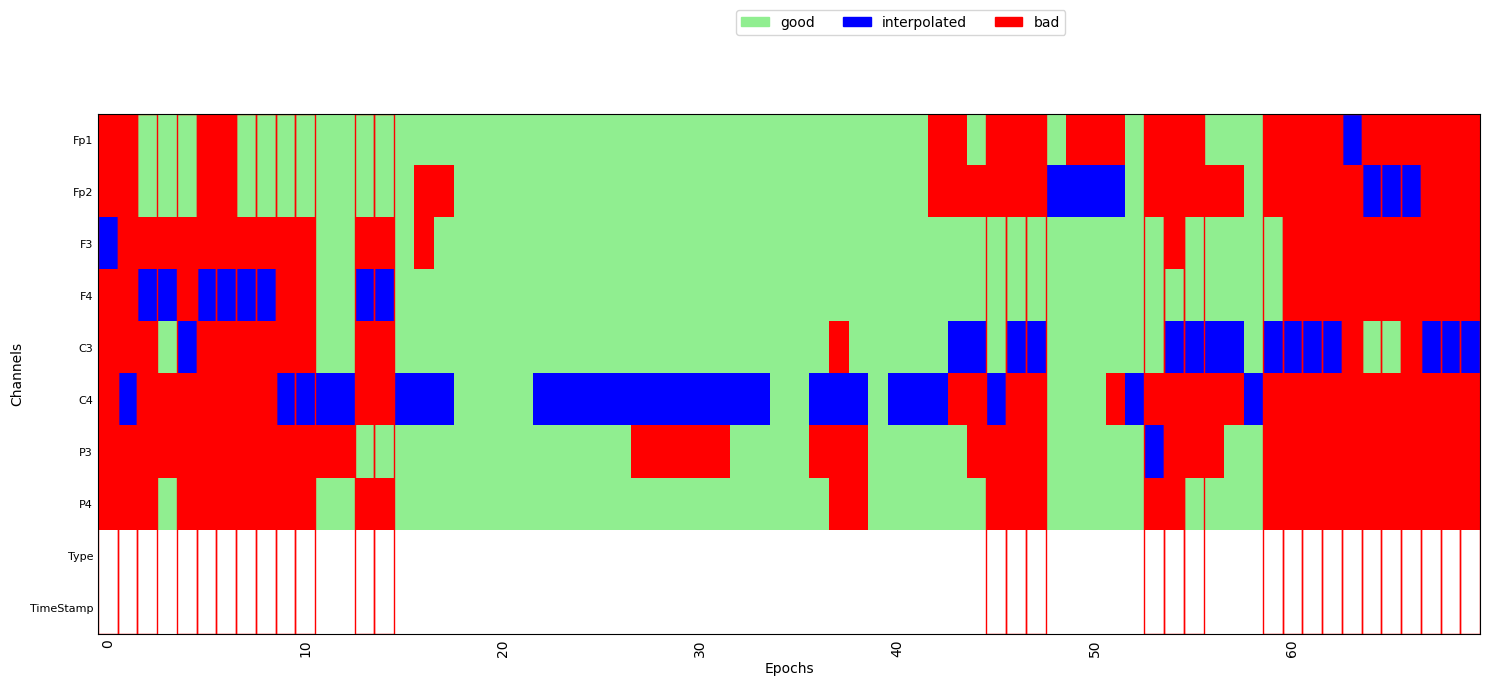

In [143]:
# Visualize the rejection log
fig, ax = plt.subplots(figsize=[15, 7])
reject_log.plot(orientation='horizontal', ax=ax, aspect='auto', show_names=True);

In [144]:
#ICA 

# Instantiate
ica = mne.preprocessing.ICA(n_components=ica_n_components,
            random_state=ica_rand_state,)

# Fit
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,17 iterations on epochs (7708 samples)
ICA components,7
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


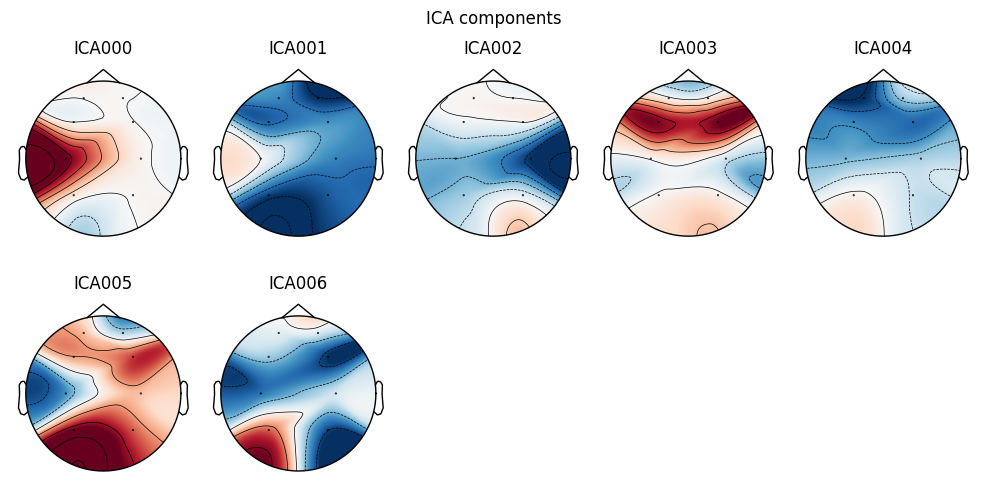

In [145]:
ica.plot_components();

In [146]:
# find bad components

ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=[chan for chan in raw.info['ch_names'] if 'EOG' in chan], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step  # lower the threshold by z_step each iteration

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))

# print the components to exclude
print("Components to exclude: " + str(eog_indices))

Final z threshold = 2.05
Components to exclude: [1, 5]


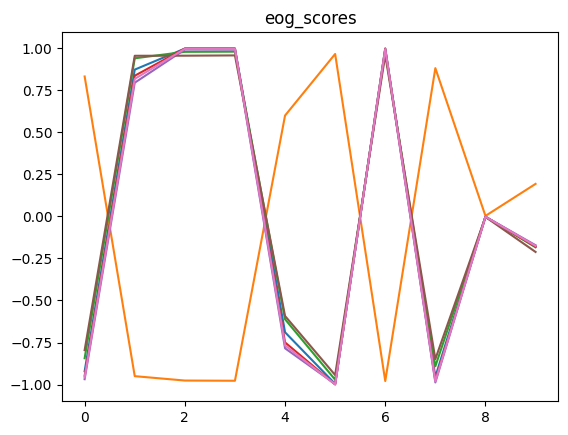

In [147]:
# plot eog_scores
plt.figure()
plt.plot(eog_scores)
plt.title('eog_scores')
plt.show()

In [148]:
# save ICA object 
# ica.save('data/training/'  + participant_id + '-ica.fif')

In [149]:
# find events and separate into categories
events = mne.find_events(raw_filt, stim_channel='Type')

# create new lists for each event type
events_real = []
events_ai = []

# separate events base of value in type channel
for e in events:
    if e[2] == 1:
        events_real.append(e)
    elif e[2] == 2:
        events_ai.append(e)

# print number of events in each category
print('Number of real events: ' + str(len(events_real)))
print('Number of ai events: ' + str(len(events_ai)))


Number of real events: 23
Number of ai events: 24


In [150]:
# remapping events to match MNE conventions

# create dictionary to map events to
events_dict = {'real': 1, 'ai': 2}

# make a copy of events array
events_remapped = events.copy()

# create a dict to store the number of events in each category
event_counts = {}

# loop through the dictionary and remap the events array using a mask, then print the length of each category
for k, v in events_dict.items():
    mask = np.isin(events_remapped[:,2], v)
    event_counts[k] = len(events_remapped[mask])
    print(f"Category {str(k)}: {event_counts[k]}")

Category real: 23
Category ai: 24


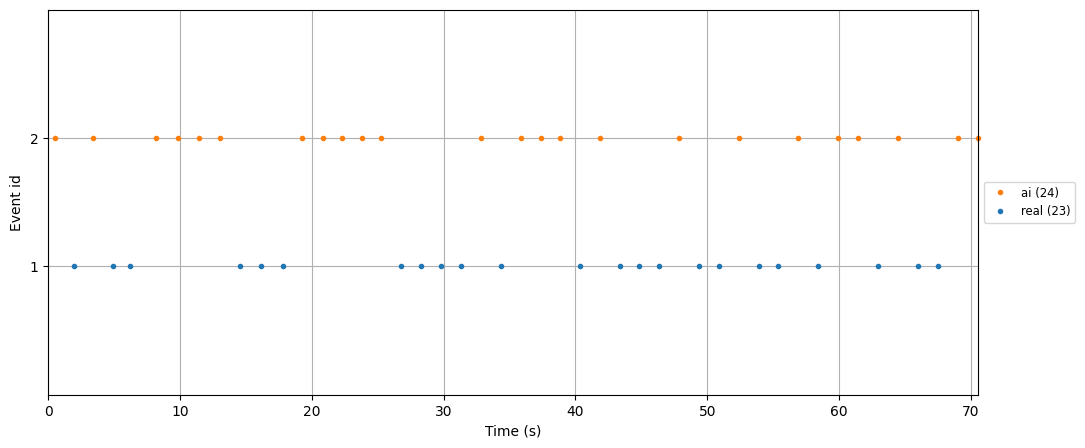

In [151]:
# plot the remapped events array
fig, ax = plt.subplots(figsize=[15, 5])
mne.viz.plot_events(events_remapped, raw_filt.info['sfreq'], event_id=events_dict, axes=ax);

In [152]:
# make epochs
epochs = mne.Epochs(raw_filt, events_remapped, tmin=tmin, tmax=tmax, baseline=baseline, proj=False, detrend=1, preload=True, event_repeated='merge',
                    reject = dict(eeg=1e-3))

print(epochs)

labels = epochs.events[:, -1:]
print(labels.T)

psd = epochs.compute_psd(method='multitaper', tmin=0, tmax=2, fmin=2, fmax=30, picks='eeg')




<Epochs |  34 events (all good), -0.199219 – 2 s, baseline -0.2 – 0 s, ~1.5 MB, data loaded,
 '1': 18
 '2': 16>
[[2 1 1 2 2 2 2 2 1 1 1 1 2 1 2 2 2 1 2 1 1 1 2 1 1 2 1 1 2 1 2 2 1 1]]


In [153]:
psds = []

psd = 10 * np.log10(psd)
reshaped_psd = psd.reshape(len(psd), len(psd[0]) * len(psd[0][0])) # convert the data into a two dimensional array
psds.append(reshaped_psd)



In [154]:
clf = RidgeClassifier()
sam = np.asarray(psds)
lab = np.asarray(labels.T)
preds = np.empty(len(labels))

sam_train, sam_test, lab_train, lab_test = train_test_split(sam[0], lab[0], test_size=0.25, random_state=42)
clf.fit(sam_train, lab_train)
savefile = '../data/classifier_save.sav'
# pickle.dump(clf, open(savefile, 'wb'))
preds = clf.predict(sam_test)

report = classification_report(lab_test, preds)
acc = accuracy_score(lab_test, preds)
print(acc)
print(lab_test)
print(preds)
print("The accuracy for this participant: " + str(acc * 100) + "% \n")

0.3333333333333333
[2 1 1 1 1 1 1 2 1]
[1 1 2 2 1 1 2 1 2]
The accuracy for this participant: 33.33333333333333% 

